## Direct solve

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      953
Number of nonzeros in inequality constraint Jacobian.:      204
Number of nonzeros in Lagrangian Hessian.............:    21115

Total number of variables............................:      205
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:      204
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:      153
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1000000e+00 1.10e+00 2.72e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00  

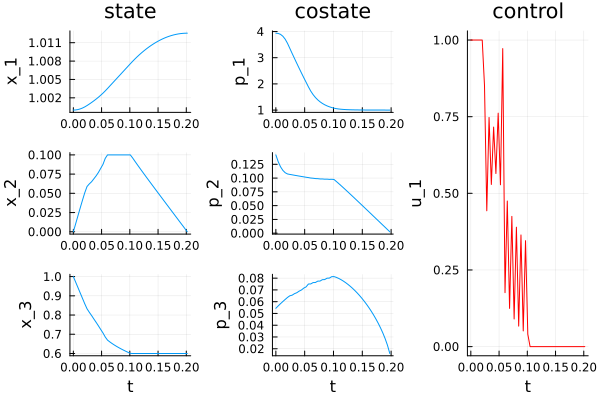

In [4]:
using OptimalControl

# Parameters
Cd = 310
Tmax = 3.5
β = 500
b = 2
t0 = 0
r0 = 1
v0 = 0
vmax = 0.1
m0 = 1
mf = 0.6
x0 = [ r0, v0, m0 ]

ocp = Model()

time!(ocp, :initial, t0) # if not provided, final time is free
state!(ocp, 3) # state dim
control!(ocp, 1) # control dim

constraint!(ocp, :initial, x0)
constraint!(ocp, :control, u -> u[1], 0, 1) # constraints can be labeled or not
constraint!(ocp, :state, (x, u) -> x[1], r0, Inf,  :state_con1)
constraint!(ocp, :state, (x, u) -> x[2], 0, vmax,  :state_con2)
constraint!(ocp, :state, (x, u) -> x[3], mf, m0,   :state_con3)

objective!(ocp, :mayer,  (t0, x0, tf, xf) -> xf[1], :max)

function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r - 1))
    F = [ v, -D/m - 1/r^2, 0 ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0, Tmax/m, -b*Tmax ]
    return F
end

F(x, u) = F0(x) + u*F1(x)

constraint!(ocp, :dynamics, F)

# Solve
N = 50
sol = solve(ocp, N)
plot(sol)

## Indirect solve

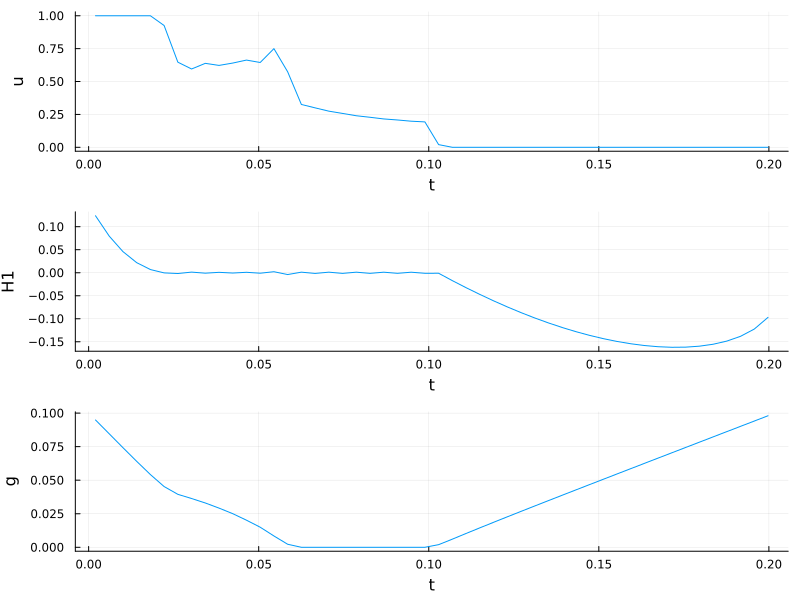

Initial guess:
[3.937605540052267, 0.14208171543627848, 0.0543688970238206, 0.022193754970103147, 0.06254603673392706, 0.06254603673392706, 0.19974379473092835]
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.313435e+00     0.000000e+00        38.804615
     2     1.426673e+00     9.299704e-02         0.869907
     3     2.433999e-01     1.736504e-02         0.073600
     4     5.431356e-01     4.880972e-03         0.072459
     5     3.563088e-01     8.360399e-05         0.156771
     6     6.799500e-01     1.120822e-03         0.777406
     7     4.584818e-01     3.734772e-03         0.066528
     8     1.082981e-01     2.224131e-03         0.074434
     9     1.466825e-01     1.085315e-03         0.165073
    10     9.621615e-02     2.955975e-04         0.066211
    11     1.449610e-01     1.085315e-03         0.053636
    12     8.765040e-02     2.931511e-04         0.168287
    13     5.326057e-02     2.71

0.20204744057204832

In [5]:
using MINPACK

# Bang controls
u0(x, p) = 0
u1(x, p) = 1

# Computation of singular control of order 1
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us(x, p) = -H001(x, p) / H101(x, p)

# Computation of boundary control
remove_constraint!(ocp, :state_con1)
remove_constraint!(ocp, :state_con3)
constraint!(ocp, :boundary, (t0, x0, tf, xf) -> xf[3], mf, :final_con) # one value => equality (not boxed inequality); changed to equality constraint for shooting
#
g(x) = constraint(ocp, :state_con2, :upper)(x, 0) # g(x, u) ≥ 0 (cf. nonnegative multiplier)
ub(x, _) = -Ad(F0, g)(x) / Ad(F1, g)(x)
μb(x, p) = H01(x, p) / Ad(F1, g)(x)

f0 = Flow(ocp, u0)
f1 = Flow(ocp, u1)
fs = Flow(ocp, us)
fb = Flow(ocp, ub, (x, _) -> g(x), μb)

# Shooting function
function shoot!(s, p0, t1, t2, t3, tf) # B+ S C B0 structure

    x1, p1 = f1(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    x3, p3 = fb(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)
    s[1] = constraint(ocp, :final_con)(t0, x0, tf, xf)
    s[2:3] = pf[1:2] - [ 1, 0 ]
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = g(x2)
    s[7] = H0(xf, pf) # free tf

end

# Initialisation from direct solution
t = sol.T; t = (t[1:end-1] + t[2:end]) / 2
x = [ sol.X[i, 1:3] for i ∈ 1:N+1 ]; x = (x[1:end-1] + x[2:end]) / 2
u = [ sol.U[i, 1  ] for i ∈ 1:N+1 ]; u = (u[1:end-1] + u[2:end]) / 2
p = [ sol.P[i, 1:3] for i ∈ 1:N   ]
                
u_plot = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
H1_plot = plot(t, H1.(x, p), xlabel = "t", ylabel = "H1", legend = false)
g_plot = plot(t, g.(x), xlabel = "t", ylabel = "g", legend = false)
display(plot(u_plot, H1_plot, g_plot, layout=(3,1), size=(800,600)))

η = 1e-3
t13 = t[ abs.(H1.(x, p)) .≤ η ]
t23 = t[ 0 .≤ g.(x) .≤ η ]
p0 = p[1]
t1 = min(t13...)
t2 = min(t23...)
t3 = max(t23...)
tf = t[end]
ξ = [ p0 ; t1 ; t2 ; t3 ; tf ]

println("Initial guess:\n", ξ)

# Solve
nle = (s, ξ) -> shoot!(s, ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])
sol = fsolve(nle, ξ, show_trace=true)
println(sol)

# Plots
p0 = sol.x[1:3]
t1 = sol.x[4]
t2 = sol.x[5]
t3 = sol.x[6]
tf = sol.x[7]


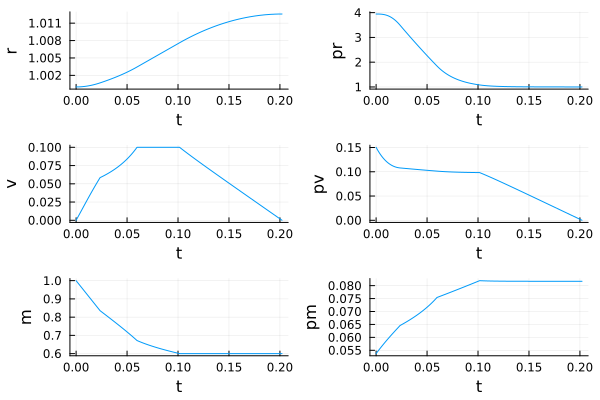

In [12]:
# Plots
f = f1 * (t1, fs) * (t2, fb) * (t3, f0); # concatenation of the Hamiltonian flows
ode_sol = f((t0, tf), x0, p0)
t = ode_sol.t
x = [ ode_sol[1:3, j] for j in 1:size(t, 1) ]
p = [ ode_sol[4:6, j] for j in 1:size(t, 1) ]
N = length(t)

r_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "r", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
m_plot  = plot(t, [ x[i][3] for i=1:N ], xlabel = "t", ylabel = "m", legend = false)
pr_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "pr", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
pm_plot = plot(t, [ p[i][3] for i=1:N ], xlabel = "t", ylabel = "pm", legend = false)
x_plot = plot(r_plot, pr_plot, v_plot, pv_plot, m_plot, pm_plot, layout = (3,2))
display(x_plot)